#  이상치 분석
### 데이터에 대한 분포를 가정하지 않는 Isolation forest, OneClassSVM
### OneClassSVM은 semi-supervised에도 적용 가능
https://towardsdatascience.com/anomaly-detection-in-python-part-2-multivariate-unsupervised-methods-and-code-b311a63f298b

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')

## 1. IsolationForest

In [2]:
from sklearn.ensemble import IsolationForest

In [3]:
# Create Artificial Data with Multivariate Outliers
d1 = np.random.multivariate_normal(mean = np.array([-.5, 0]),
                               cov = np.array([[1, 0], [0, 1]]), size = 100)
d2 = np.random.multivariate_normal(mean = np.array([15, 10]),
                               cov = np.array([[1, 0.3], [.3, 1]]), size = 100)
outliers = np.array([[0, 10],[0, 9.5]])
d = pd.DataFrame(np.concatenate([d1, d2, outliers], axis = 0), columns = ['Var 1', 'Var 2'])
d

,Var 1,Var 2
0,0.626837,-0.332014
1,-2.107405,1.851261
2,-0.737168,-0.091207
3,-0.697674,0.504645
4,-1.218453,-1.466282
...,...,...
197,16.719345,12.326823
198,15.919763,10.180422
199,15.937024,10.712913
200,0.000000,10.000000


<AxesSubplot:>

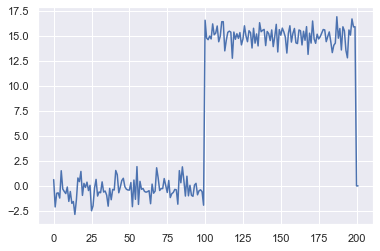

In [4]:
d['Var 1'].plot()

<AxesSubplot:>

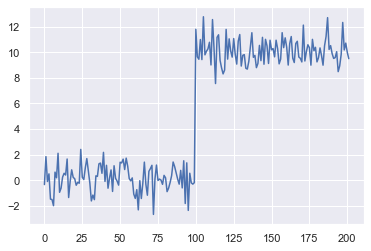

In [5]:
d['Var 2'].plot()

<AxesSubplot:xlabel='Var 1', ylabel='Var 2'>

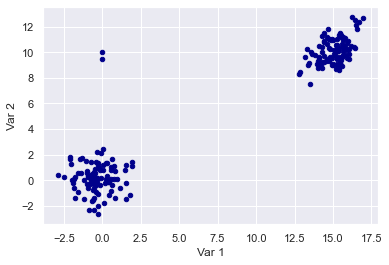

In [16]:
d.plot.scatter(x='Var 1', y='Var 2', c='DarkBlue')

<Figure size 720x320 with 0 Axes>

Text(0.5, 0, 'Var 1')

Text(0, 0.5, 'Var 2')

Text(0.5, 1.0, 'Anonaly scores')

<Figure size 720x320 with 0 Axes>

Text(0.5, 0, 'Var 1')

Text(0, 0.5, 'Var 2')

Text(0.5, 1.0, 'Contamination = 0.01')

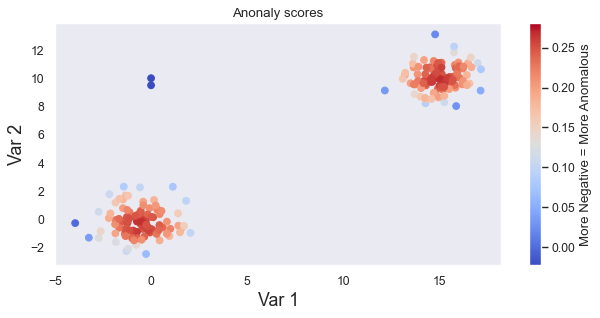

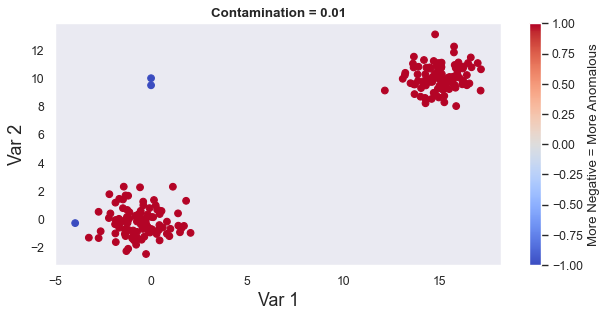

In [31]:
################### Train Isolation Forest #################
model  =  IsolationForest(n_estimators=50, max_samples=500, contamination=.01, max_features=2, 
                         bootstrap=False, n_jobs=1, random_state=1, verbose=0, warm_start=False).fit(d)
# Get Anomaly Scores and Predictions
anomaly_score = model.decision_function(d)
predictions = model.predict(d)
######### Visualize Anomaly scores and Anomaly Status ########
plt.figure(figsize = (9, 4), dpi = 80)
s = plt.scatter(d['Var 1'], d['Var 2'], c = anomaly_score, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel('Var 1', fontsize = 16)
plt.ylabel('Var 2', fontsize = 16)
plt.grid()
plt.title('Anonaly scores')

# To Plot Predictions
plt.figure(figsize = (9, 4), dpi = 80)
s = plt.scatter(d['Var 1'], d['Var 2'], c = predictions, cmap = 'coolwarm')
plt.colorbar(s, label = 'More Negative = More Anomalous')
plt.xlabel('Var 1', fontsize = 16)
plt.ylabel('Var 2', fontsize = 16)
plt.grid()
plt.title('Contamination = 0.01', weight = 'bold')

## 2. OneClassSVM

In [ ]:
# Create Fake data to classify 
x_fake  =  pd.DataFrame(np.random.uniform(-5, 19, (35000, 2)), columns = ['Var 1', 'Var 2'])

In [43]:
model = OneClassSVM(kernel='rbf', degree=5, gamma=0.08, coef0=0.0, tol=0.001, nu=0.01, 
                    shrinking=True, cache_size=200, verbose=False, max_iter=- 1).fit(x_fake)

model_predictions = model.predict(x_fake)
x_fake['Predicted'] = model_predictions
x_fake
normal = x_fake.loc[x_fake['Predicted'] == 1, :]
anomalies = x_fake.loc[x_fake['Predicted'] == -1, :]

,Var 1,Var 2,Predicted
0,9.981504,8.539519,1
1,0.246391,14.734863,1
2,0.985948,4.295773,1
3,-2.634824,18.482573,1
4,-3.247782,12.971809,1
...,...,...,...
34995,6.389814,5.865214,1
34996,1.722202,2.117878,1
34997,4.956009,16.448613,1
34998,8.880623,15.714611,1


,Var 1,Var 2,Predicted
74,18.976556,12.309367,-1
109,3.726536,-0.288658,-1
214,7.675245,3.242189,-1
302,3.118825,7.554598,-1
362,7.615818,3.282240,-1
...,...,...,...
34437,13.228638,-4.992938,-1
34722,10.753571,-0.416840,-1
34854,7.145062,10.893143,-1
34878,6.766123,3.194778,-1


(416, 3)

<AxesSubplot:xlabel='Var 1', ylabel='Var 2'>

<AxesSubplot:xlabel='Var 1', ylabel='Var 2'>

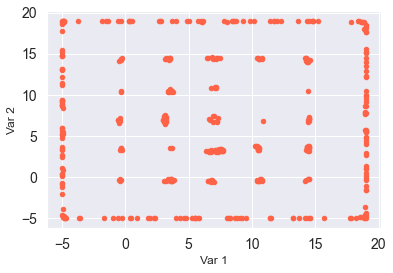

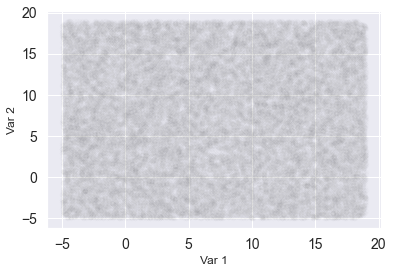

In [49]:
anomalies
column1 = x_fake.columns[0]
column2 = x_fake.columns[1]
anomalies.plot.scatter(column1, column2, color = 'tomato', fontsize = 14)
normal.plot.scatter(column1, column2, color = 'grey', fontsize = 14, alpha=0.01)

### SVM gamma에 따른 이상치 판별

In [52]:
from sklearn.svm import OneClassSVM

def plot_anomaly2(data, predicted, ax):
    data2 = data.copy()
    data2['Predicted'] = predicted
    
    normal = data2.loc[data2['Predicted'] == 1, :]
    anomalies = data2.loc[data2['Predicted'] == -1, :]
    
    # Make Scatterplot
    column1 = data.columns[0]
    column2 = data.columns[1]
    
    
    anomalies.plot.scatter(column1, column2, color = 'tomato', fontsize = 14,  sharex = False, ax=ax)
    normal.plot.scatter(column1, column2, color = 'grey', fontsize = 14,  sharex = False, ax = ax, alpha=0.01)
    #plt.grid(linestyle = '--')
    
    plt.xlabel(column1, fontsize = 14, weight = 'bold')
    plt.ylabel(column2, fontsize = 14, weight = 'bold')
    return ax

Text(0.5, 1.0, 'Gamma: 0.01')

Text(0.5, 1.0, 'Gamma: 0.025')

Text(0.5, 1.0, 'Gamma: 0.05')

Text(0.5, 1.0, 'Gamma: 0.1')

Text(0.5, 1.0, 'Gamma: 0.3')

Text(0.5, 1.0, 'Gamma: 0.6')

Text(0.5, 1.0, 'Gamma: 0.9')

Text(0.5, 1.0, 'Gamma: 2')

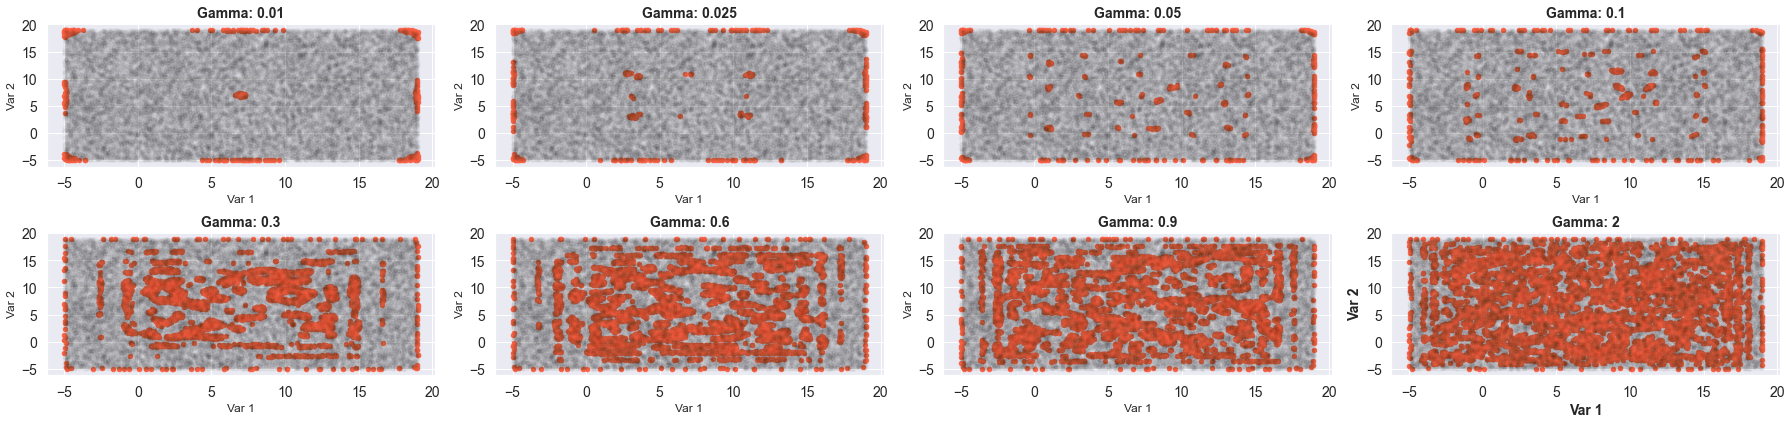

In [54]:
# Visualize effect of changing Gamma
gammas = [.01, .025, .05, .1,.3, .6, .9, 2]
fig, axes = plt.subplots(2, 4, figsize = (25, 6), tight_layout = True)
for i, ax in zip(range(len(gammas)), axes.flatten()):
    gamma = gammas[i]
    model = OneClassSVM(kernel='rbf', degree=5, gamma=gamma, coef0=0.0, tol=0.001, nu=0.01, 
                        shrinking=True, cache_size=200, verbose=False, max_iter=- 1).fit(x_fake)
    
    model_predictions = model.predict(x_fake)
    #x_fake['Predictions'] = model_predictions
    ax = plot_anomaly2(x_fake, model_predictions, ax)
    
    ax.scatter(x_fake.iloc[:, 0], x_fake.iloc[:, 1], color = 'k', s = 10, alpha=0.01)
    
    #ax.scatter(all_data.iloc[:, 0], all_data.iloc[:, 1], color = 'k', s = 10)
    ax.set_title('Gamma: {}'.format(np.around(gamma,6)), weight = 'bold', fontsize = 14)

## 3. EllipticEnvelope method
https://medium.com/analytics-vidhya/anomaly-detection-in-python-part-1-basics-code-and-standard-algorithms-37d022cdbcff

In [12]:
from sklearn.covariance import EllipticEnvelope

In [33]:
### Create the Data
d1 = np.random.multivariate_normal(mean = np.array([-.5, 0]),
                               cov = np.array([[1, 0], [0, 1]]), size = 100)
d2 = np.random.multivariate_normal(mean = np.array([15, 10]),
                               cov = np.array([[1, 0.3], [.3, 1]]), size = 100)
outliers = np.array([[0, 10],[0, 9.5]])
d1[0:5]
d2[0:5]
outliers

array([[ 0.81025546,  2.00017913],
       [ 0.0590736 ,  0.26402116],
       [-0.31936532, -0.89771226],
       [-0.21469495,  0.51875961],
       [ 0.53190614,  1.42422242]])

array([[16.18790961, 10.07928528],
       [15.85032123, 11.28500887],
       [14.80456806,  8.51390746],
       [16.45319895, 10.32538057],
       [14.68315282, 11.51497552]])

array([[ 0. , 10. ],
       [ 0. ,  9.5]])

In [34]:
d = pd.DataFrame(np.concatenate([d1, d2, outliers], axis = 0), columns = ['Var 1', 'Var 2'])
d

,Var 1,Var 2
0,0.810255,2.000179
1,0.059074,0.264021
2,-0.319365,-0.897712
3,-0.214695,0.518760
4,0.531906,1.424222
...,...,...
197,15.902859,9.446401
198,14.500325,9.286163
199,14.889501,9.380023
200,0.000000,10.000000


EllipticEnvelope(contamination=0.075, random_state=0)

<Figure size 648x288 with 0 Axes>

Text(0.5, 0, 'Var 1')

Text(0, 0.5, 'Var 2')

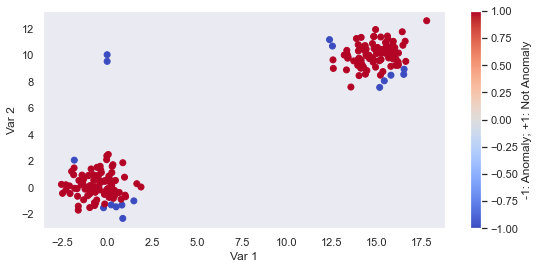

In [27]:
d = pd.DataFrame(np.concatenate([d1, d2, outliers], axis = 0), columns = ['Var 1', 'Var 2'])
### The outliers added above are what we want to detect ####
############# Use Mahalanobis distance method to detect them ####
# Define the Elliptic Envelope
el = EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, 
                      contamination=0.075, random_state=0)
# Fit the data - this is where FastMCD is used by sklearn
el.fit(d)
# Create column that shows anomaly status
d['Anomaly or Not'] = el.predict(d)
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (9, 4))
ax = plt.scatter(d['Var 1'], d['Var 2'], c = d['Anomaly or Not'], cmap = 'coolwarm')
plt.xlabel('Var 1')
plt.ylabel('Var 2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')
plt.grid()

## 4. What if we dont have an estimate of Contamination?

### mahalanobis 거리를 사용한다. contamination을 무엇을 사용해도 상관이 없음

EllipticEnvelope(contamination=0.5, random_state=0)

<Figure size 648x288 with 0 Axes>

Text(0.5, 0, 'Var 1')

Text(0, 0.5, 'Var 2')

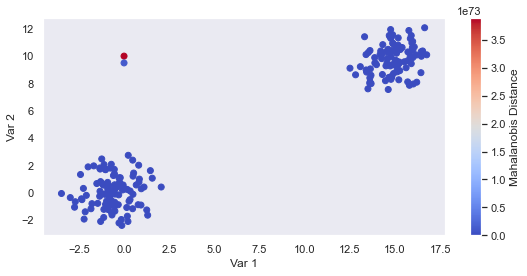

In [41]:
###### Fit Elliptic Envelope ##############
contamination = .5 # We can set any value here as we will now use our own threshold
el = EllipticEnvelope(store_precision=True, assume_centered=False, support_fraction=None, 
                      contamination=contamination, random_state=0)
# Fit the data
el.fit(d)
############# New Part ################
# Create column that measures Mahalanobis distance
d['Mahalanobis Distance'] = el.mahalanobis(d)

# Create scatterplot and color the anomalies differently
plt.figure(figsize = (9, 4))
ax = plt.scatter(d['Var 1'], d['Var 2'], c = d['Mahalanobis Distance'], cmap = 'coolwarm')
#plt.title('Contamination = Does not matter for this method', weight = 'bold')
#ax = sns.scatterplot(d['Var 1'], d['Var 2'], c = d['Anomaly or Not'])
plt.xlabel('Var 1')
plt.ylabel('Var 2')
plt.colorbar(label = 'Mahalanobis Distance')
plt.grid()

NOTE: The Mahalanobis distance method works even for hundreds of features. For ease of Visualization, I have used 2 variables for the discussion.

# End